<a href="https://colab.research.google.com/github/Linar23/Computer_vision/blob/master/Object_detetcion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Object Detection with custom dataset in Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

**Requirements are only dataset images and annotations file.**


**Colab Runtime type: Python2, GPU enabled.**



#Create Dataset

Before running notebook, we need to create dataset:

1.   Collect various pictures of objects to detect
2.   Rename image filenames with format `objectclass_seq.jpg`
3.   In LabelImg create annotation files. LabelImg saves annotations as XML files in PASCAL VOC format
4.   Create dataset.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
dataset.zip file
|-images directory
  |-image files (filename format: objectclass_seq.jpg)
|-annotations directory
  |-xmls directory
    |-annotation files (filename format: objectclass_seq.xml)
```

Where `objectclass` is the class name, `seq` is a sequence number (001, 002, 003, ...)



# Install required packages

In [2]:
%cd ~
!apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 jupyter pillow lxml matplotlib PyDrive
!pip install -q pycocotools

!git clone https://github.com/tensorflow/models.git

%cd models/research

!protoc object_detection/protos/*.proto --python_out=.

%set_env PYTHONPATH=/root/models/research:/root/models/research/slim

!python object_detection/builders/model_builder_test.py

/root
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-tk is already the newest version (2.7.15~rc1-1).
The following additional packages will be installed:
  libjbig0 liblcms2-2 libprotobuf10 libprotoc10 libtiff5 libwebp6
  libwebpdemux2 libwebpmux3 libxslt1.1 python-bs4 python-chardet
  python-html5lib python-olefile python-pkg-resources python-six
  python-webencodings
Suggested packages:
  liblcms2-utils python-genshi python-lxml-dbg python-lxml-doc python-pil-doc
  python-pil-dbg python-setuptools
The following NEW packages will be installed:
  libjbig0 liblcms2-2 libprotobuf10 libprotoc10 libtiff5 libwebp6
  libwebpdemux2 libwebpmux3 libxslt1.1 protobuf-compiler python-bs4
  python-chardet python-html5lib python-lxml python-olefile python-pil
  python-pkg-resources python-six python-webencodings
0 upgraded, 19 newly installed, 0 to remove and 5 not upgraded.
Need to get 3,740 kB of archives.
After this operation, 14.6 MB of ad

# Download and extract dataset


*   Change name attribute in label_map, accordingly with objectclass filename.
*   Substitute fileId value with your dataset.zip id in Google Drive.

In [3]:
%mkdir ~/datalab
%cd ~/datalab

!echo "item { id: 1 name: 'price'}" > label_map.pbtxt

fileId = '1qE-E8uYD2B3Ojqy--TMTDhvN9R2jmVy6'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

/root/datalab
Extracted zip file 1qE-E8uYD2B3Ojqy--TMTDhvN9R2jmVy6.zip


#Empty png files
Create empty png mask files to avoid error in create_pet_tf_record.py, they are not used in training model.

In [4]:
%cd ~/datalab/annotations
!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/root/datalab/annotations


# Create TFRecord

In [5]:
%cd ~/datalab

!python ~/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record


/root/datalab
/root/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


# Download pretrained model

Cell downloads **faster_rcnn_inception_v2_coco** model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [6]:
%cd ~/datalab
%ls

/root/datalab
annotations/  images/  label_map.pbtxt  tf_train.record  tf_val.record


In [7]:
%cd ~/datalab

import os
import shutil
import glob
import urllib
import tarfile

MODEL = 'ssdlite_mobilenet_v2_coco_2018_05_09'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/root/datalab


# Edit model config file
To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.


In [8]:
%cd ~/datalab

import re

filename = '/root/datalab/pretrained_model/pipeline.config'
#filename = '/content/models/research/object_detection/samples/configs/ssd_resnet50_v1_fpn_shared_box_predictor_640x640_coco14_sync_2018_07_03.config'
with open(filename) as f:
  s = f.read()
with open(filename, 'w') as f:
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/root/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record', '/root/datalab/tf_train.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record', '/root/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/root/datalab/label_map.pbtxt', s)
  s = re.sub('num_classes: 90', 'num_classes: 1', s)
  f.write(s)


/root/datalab


In [9]:
f = open('/root/datalab/pretrained_model/pipeline.config', 'r')
file_contents = f.read()
print (file_contents)
f.close()

model {
  ssd {
    num_classes: 1
    image_resizer {
      fixed_shape_resizer {
        height: 300
        width: 300
      }
    }
    feature_extractor {
      type: "ssd_mobilenet_v2"
      depth_multiplier: 1.0
      min_depth: 16
      conv_hyperparams {
        regularizer {
          l2_regularizer {
            weight: 3.99999989895e-05
          }
        }
        initializer {
          truncated_normal_initializer {
            mean: 0.0
            stddev: 0.0299999993294
          }
        }
        activation: RELU_6
        batch_norm {
          decay: 0.999700009823
          center: true
          scale: true
          epsilon: 0.0010000000475
          train: true
        }
      }
      use_depthwise: true
    }
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 

# Train model
Set num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [0]:
%rm -rf ~/datalab/trained_model
%mkdir ~/datalab/trained_model

#Setup ngrok and run TensorBoard on Colab

In [21]:
%cd ~

#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

LOG_DIR = '/root/datalab/trained_model'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

get_ipython().system_raw('~/ngrok http 6006 &')

! curl -s http://localhost:4040/api/tunnels | python2 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

/root
http://83369349.ngrok.io


In [22]:
import warnings
warnings.filterwarnings('ignore')

%cd /root/datalab

!python ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=/root/datalab/pretrained_model/pipeline.config \
    --model_dir=/root/datalab/trained_model \
    --alsologtostderr \
    --num_train_steps=25000 \
    --num_eval_steps=50


/root/datalab
/root/models/research/object_detection/utils/visualization_utils.py:27: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/root/models/research/object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/root/models/research/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/root/models/research/object_detection/eval_util.py", line 27, in <module>
    from object_detection.metrics import coco_evaluation
  File "/root/models/research/object_detection/metrics/coco_evaluation.py", line 20, in <module>
    from object_detection.metrics import coco_tools
  File "/root/models/research/object_detectio

KeyboardInterrupt: ignored

#Export trained model

Export trained model with highest step number in filename.

In [43]:
%cd ~/datalab/trained_model
%ls

/root/datalab/trained_model
checkpoint
eval_0/
events.out.tfevents.1542016278.43b8ecd0851d
frozen_inference_graph.pb
graph.pbtxt
model.ckpt-7271.data-00000-of-00001
model.ckpt-7271.index
model.ckpt-7271.meta
model.ckpt-7694.data-00000-of-00001
model.ckpt-7694.index
model.ckpt-7694.meta
model.ckpt-8135.data-00000-of-00001
model.ckpt-8135.index
model.ckpt-8135.meta
model.ckpt-8558.data-00000-of-00001
model.ckpt-8558.index
model.ckpt-8558.meta
model.ckpt-8980.data-00000-of-00001
model.ckpt-8980.index
model.ckpt-8980.meta
model.ckpt.data-00000-of-00001
model.ckpt.index
model.ckpt.meta
pipeline.config
saved_model/


#Download model

In [0]:
from google.colab import files
files.download("/root/datalab/trained_model/model.ckpt-7271.data-00000-of-00001")
files.download("/root/datalab/trained_model/model.ckpt-7271.index")
files.download("/root/datalab/trained_model/model.ckpt-7271.meta")

In [24]:
!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/datalab/pretrained_model/pipeline.config \
    --output_directory=/root/datalab/trained_model \
    --trained_checkpoint_prefix=/root/datalab/trained_model/model.ckpt-7271



Instructions for updating:
Please switch to tf.train.get_or_create_global_step
W1112 13:25:49.864483 139742321174400 tf_logging.py:125] From /root/models/research/object_detection/exporter.py:328: get_or_create_global_step (from tensorflow.contrib.framework.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
W1112 13:25:49.869767 139742321174400 tf_logging.py:125] From /root/models/research/object_detection/exporter.py:482: print_model_analysis (from tensorflow.contrib.tfprof.model_analyzer) is deprecated and will be removed after 2018-01-01.
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for det

#Upload jpg image for inference

In [40]:
%cd ~/datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

/root/datalab


Saving IMG_2419.JPG to IMG_2419.JPG
saved file IMG_2419.JPG


# Run inference


/root/models/research/object_detection
1.12.0


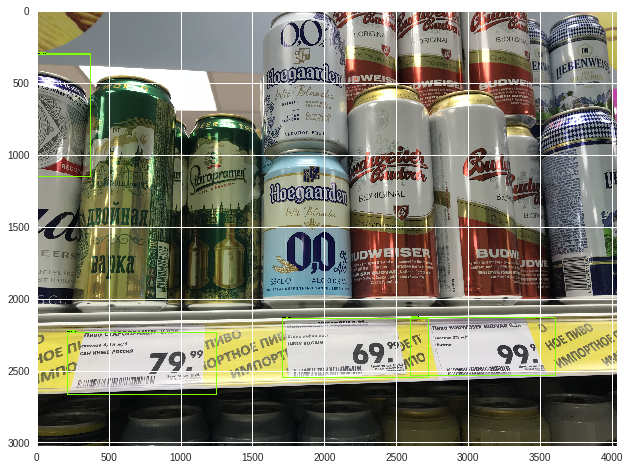

In [41]:
%cd ~/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

print(tf.__version__)
#if tf.__version__ < '1.4.0':
#  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')  
  
# This is needed to display the images.
%matplotlib inline

from utils import label_map_util

from utils import visualization_utils as vis_util

# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/datalab/trained_model' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/datalab', 'label_map.pbtxt')

NUM_CLASSES = 1

detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)


# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict


for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  